# Movie Review Classification
### CS 175

##### Darren Lim
##### Justin Lonh
##### Jerson Villanueva


## IMPORT

Import the necessary libraries and modules

In [0]:
pip install tensorflow_datasets

In [0]:
from string import punctuation
from os import listdir
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from numpy import array
from numpy import zeros
from numpy import asarray
import gensim 
from gensim.models import Word2Vec

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


#from tensorflow.keras import backend

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential as Sequential
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Dropout as Dropout
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Embedding as Embedding
from tensorflow.keras.layers import Conv1D as Conv1D
from tensorflow.keras.layers import MaxPooling1D as MaxPooling1D
#from tensorflow.layers.convolutional import MaxPooling1D

from tensorflow.keras.models import load_model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We stored our Kaggle dataset into our google drive, so we mount our drive first to have access to the data.

## LOAD DATASETS

In [0]:
# mount google drive to get movie review data (uploaded to google drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = '/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/neg'
directory2 = '/content/drive/My Drive/CS175/imdb/train/pos'

# example how to use imdb dataset
# this code gets the training split from imdb dataset, shuffles it, splits into batches of 32 reviews
# then for each batch, zips together label values and text values, and prints them
# for vocab creation or if you don't need labels, can just iterate through bat['text'].numpy() to get text

imdb_train = tfds.load(name="imdb_reviews", split="train")
imdb_train = imdb_train.shuffle(1024).prefetch(tf.data.experimental.AUTOTUNE)

vocab = None
imdbVocab = None

## TOKENIZE VOCAB WORDS

The following code blocks will clean and create a list of vocabulary from the review text files.

In [0]:
# Following code blocks are from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
# on cleaning and recovering vocabulary from the txt files

def ReadFile(filename):
  file = None
  with open(filename) as f:
    file = f.read()
  return file

def clean_file(doc):
  # split into tokens by white space
  tokens = doc.split()
  # remove punctuation from each token\
  table = str.maketrans('', '', punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1 and word != 'br']
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(word) for word in tokens]
  return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = ReadFile(filename)
	# clean doc
	tokens = clean_file(doc)
	# update counts
	vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)

In [0]:
'''
This code block grabs all of the vocab words in the neg and pos text files
and cleans out the words that occur the least.
Bag of words
'''
# define vocab
vocab = Counter()
imdbVocab = Counter()
# add all docs to vocab
neg_directory = '/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/neg'
pos_directory = '/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/pos'
process_docs(neg_directory, vocab, True)
process_docs(pos_directory, vocab, True)

# adding imdb reviews to vocab
for review in imdb_train:
  imdbVocab.update(clean_file(review['text'].numpy().decode('utf-8')))

print("total vocab kaggle: ", len(vocab))
print("total vocab imdb: ", len(imdbVocab))

# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
imdbTokens = [k for k,c in imdbVocab.items() if c >= min_occurane]

print("total vocab Kaggle after removing min occurance: ", len(tokens))
print(vocab.most_common(50))
print("total vocab IMDB after removing min occurance: ",len(imdbTokens))
print(imdbVocab.most_common(50))

total vocab kaggle:  29581
total vocab imdb:  89547
total vocab Kaggle after removing min occurance:  17576
[('film', 9984), ('movi', 6064), ('one', 5156), ('like', 3597), ('charact', 3439), ('get', 2870), ('make', 2812), ('time', 2608), ('scene', 2376), ('even', 2306), ('play', 2155), ('good', 2141), ('stori', 2092), ('see', 1977), ('would', 1844), ('much', 1825), ('also', 1757), ('go', 1742), ('way', 1683), ('seem', 1662), ('two', 1643), ('end', 1635), ('take', 1625), ('look', 1617), ('first', 1589), ('come', 1588), ('well', 1572), ('work', 1522), ('thing', 1481), ('realli', 1407), ('know', 1402), ('year', 1390), ('plot', 1376), ('perform', 1363), ('littl', 1354), ('life', 1345), ('peopl', 1304), ('love', 1272), ('bad', 1256), ('could', 1248), ('man', 1212), ('show', 1205), ('never', 1201), ('tri', 1192), ('best', 1182), ('new', 1140), ('give', 1137), ('mani', 1130), ('star', 1121), ('doesnt', 1118)]
total vocab IMDB after removing min occurance:  39515
[('movi', 49597), ('film', 462

In [0]:
data = '\n'.join(tokens)
# open file
with open('/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/vocab.txt', 'w+') as f:
  # write text
  f.write(data)

imdbData = '\n'.join(imdbTokens)
with open('/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/imdbvocab.txt', 'w+') as f:
  # write text
  f.write(imdbData)

'''
With this part of the code creating a vocab.txt file, we no longer need to run the block of code before 
to collect the vocabulary of all the txt files.
This next part, we will compare the tokens with the positive and negative reviews
and filter the vocab of those text with the vocab.txt we just created.
'''


'\nWith this part of the code creating a vocab.txt file, we no longer need to run the block of code before \nto collect the vocabulary of all the txt files.\nThis next part, we will compare the tokens with the positive and negative reviews\nand filter the vocab of those text with the vocab.txt we just created.\n'

## TOKENIZE DATASET AND FILTER WITH VOCAB

In [0]:
# turn a doc into clean tokens
def clean_txt_file(doc, vocab):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# filter out tokens not in vocab
	tokens = [w for w in tokens if w in vocab]
	tokens = ' '.join(tokens)
	return tokens

# load all files in a directory
def process_txt_files(directory, vocab, is_train):
	documents = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load the doc
		doc = ReadFile(path)
		# clean doc
		tokens = clean_txt_file(doc, vocab)
		# add to list
		documents.append(tokens)
	return documents

In [0]:

'''
This block of code takes the positive and negative review text files and filters out
the words that are not in the vocab.txt file
'''

with open('/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/vocab.txt', 'r') as f:
  vocab_file = f.read()
  vocab = vocab_file.split()
  vocab = set(vocab)
with open('/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/imdbvocab.txt', 'r') as f:
  imdbVocab_file = f.read()
  imdbVocab = imdbVocab_file.split()
  imdbVocab = set(imdbVocab)


neg_directory = '/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/neg'
pos_directory = '/content/drive/My Drive/CS175/movie-review/movie_reviews/movie_reviews/pos'
# load all training reviews
positive_docs = process_txt_files(pos_directory, vocab, True)
negative_docs = process_txt_files(neg_directory, vocab, True)

imdb_docs = list()
imdb_train_labels = list()
for review in imdb_train:
  tokens = clean_txt_file(review['text'].numpy().decode('utf-8'), imdbVocab)
  imdb_docs.append(tokens)
  imdb_train_labels.append(review['label'].numpy())
imdb_train_labels = array(imdb_train_labels)

train_docs = negative_docs + positive_docs
# train_docs is the list of vocab words we use to train our model

We can now train a model using the positive and negative words acquired from the review text files.

In [0]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_docs)

IMDBTokenizer = Tokenizer()

IMDBTokenizer.fit_on_texts(imdb_docs)

In [0]:
# sequence encode
encoded_docs_train = tokenizer.texts_to_sequences(train_docs)
imdb_encoded_train = IMDBTokenizer.texts_to_sequences(imdb_docs)

# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
ytrain = array([0 for i in range(900)] + [1 for i in range(900)])

# pad sequences IMDB
imdb_max_length = max([len(s.split()) for s in imdb_docs])
imdbXtrain = pad_sequences(imdb_encoded_train, maxlen=imdb_max_length, padding='post')

# load all test reviews
positive_lines = process_txt_files(pos_directory, vocab, False)
negative_lines = process_txt_files(neg_directory, vocab, False)

imdb_test = tfds.load(name="imdb_reviews", split="test")
imdb_test = imdb_test.shuffle(1024).prefetch(tf.data.experimental.AUTOTUNE)

imdb_testdocs = list()
imdb_test_labels = list()
for review in imdb_test:
  tokens = clean_txt_file(review['text'].numpy().decode('utf-8'), imdbVocab)
  imdb_testdocs.append(tokens)
  imdb_test_labels.append(review['label'].numpy())
imdb_test_labels = array(imdb_test_labels)

test_docs = negative_lines + positive_lines

encoded_docs_test = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')
ytest = array([0 for i in range(100)] + [1 for i in range(100)])

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

#IMDB
imdb_encoded_docs_test = IMDBTokenizer.texts_to_sequences(imdb_testdocs)
# pad sequences
imdbXtest = pad_sequences(imdb_encoded_docs_test, maxlen=imdb_max_length, padding='post')


# define vocabulary size (largest integer value)
imdb_vocab_size = len(IMDBTokenizer.word_index) + 1

In [0]:
RNNModel = None
RNNModelimdb = None

After cleaning our tokens, we now create our neural networks to train and test on.

## NEURAL NETWORKS

In [0]:
'''
Create the CNN model
'''
CNNmodel = tf.keras.Sequential()
CNNmodel.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
#model.add(Dropout(0.2))
CNNmodel.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
CNNmodel.add(MaxPooling1D(pool_size=3))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(15, activation='relu')) # can increase the amount of units
CNNmodel.add(Dense(1, activation='sigmoid'))
print(CNNmodel.summary())

# compile network
CNNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
CNNmodel.fit(Xtrain, ytrain, epochs=10, verbose=2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 942, 100)          1060800   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 935, 32)           25632     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 311, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9952)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                149295    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 16        
Total params: 1,235,743
Trainable params: 1,235,743
Non-trainable params: 0
____________________________________________

In [0]:
CNNmodelimdb = tf.keras.Sequential()
CNNmodelimdb.add(Embedding(input_dim=imdb_vocab_size, output_dim=100, input_length=imdb_max_length))
#model.add(Dropout(0.2))
CNNmodelimdb.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
CNNmodelimdb.add(MaxPooling1D(pool_size=3))
CNNmodelimdb.add(Flatten())
CNNmodelimdb.add(Dense(15, activation='relu')) # can increase the amount of units
CNNmodelimdb.add(Dense(1, activation='sigmoid'))
print(CNNmodelimdb.summary())

# compile network
CNNmodelimdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
CNNmodelimdb.fit(imdbXtrain, imdb_train_labels, epochs=10, verbose=2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1347, 100)         1681700   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1340, 32)          25632     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 446, 32)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 14272)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                214095    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 1,921,443
Trainable params: 1,921,443
Non-trainable params: 0
____________________________________________

In [0]:
"""
GloVe embedding (pre-trained word embedding)
"""

#load embedding into memory
embedding_indexes = dict()
f = open('/content/drive/My Drive/CS175/movie-review/glove_embeddings/glove.6B.100d.txt')
for l in f:
  v = l.split()
  c = asarray(v[1:], dtype='float32')
  embedding_indexes[v[0]] = c
f.close()
print('Loaded %s word vectors.' % len(embedding_indexes))

#create weight matrix

embedding_matrix = zeros((vocab_size, 100))
for w, i in tokenizer.word_index.items():
  vector = embedding_indexes.get(w)
  if vector is not None:
    embedding_matrix[i] = vector

#define model
GloveModel = tf.keras.Sequential()
GloveModel.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False))
GloveModel.add(Flatten())
GloveModel.add(Dense(15, activation='relu'))
GloveModel.add(Dense(1, activation='sigmoid'))
GloveModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(GloveModel.summary())

# fit model
GloveModel.fit(Xtrain, ytrain, epochs=10, verbose=2)

Loaded 400000 word vectors.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 942, 100)          1060800   
_________________________________________________________________
flatten_9 (Flatten)          (None, 94200)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)                1413015   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 16        
Total params: 2,473,831
Trainable params: 1,413,031
Non-trainable params: 1,060,800
_________________________________________________________________
None
Train on 1800 samples
Epoch 1/10
1800/1800 - 1s - loss: 0.7333 - accuracy: 0.5172
Epoch 2/10
1800/1800 - 0s - loss: 0.6189 - accuracy: 0.6372
Epoch 3/10
1800/1800 - 0s - loss: 0.3803 - accuracy: 0.8489

Loaded 400000 word vectors.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 942, 100)          1060800   
_________________________________________________________________
flatten_10 (Flatten)         (None, 94200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                1413015   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 16        
Total params: 2,473,831
Trainable params: 1,413,031
Non-trainable params: 1,060,800
_________________________________________________________________
None
Train on 1800 samples
Epoch 1/10
1800/1800 - 1s - loss: 0.7118 - accuracy: 0.5072
Epoch 2/10
1800/1800 - 0s - loss: 0.6812 - accuracy: 0.4978
Epoch 3/10
1800/1800 - 0s - loss: 0.6299 - accuracy: 0.621

In [0]:
#create weight matrix

embedding_matrix_imdb = zeros((imdb_vocab_size, 100))
for w, i in IMDBTokenizer.word_index.items():
  vector = embedding_indexes.get(w)
  if vector is not None:
    embedding_matrix_imdb[i] = vector

#define model
GloveModelimdb = tf.keras.Sequential()
GloveModelimdb.add(Embedding(imdb_vocab_size, output_dim=100, weights=[embedding_matrix_imdb], input_length=imdb_max_length, trainable=False))
GloveModelimdb.add(Flatten())
GloveModelimdb.add(Dense(15, activation='relu'))
GloveModelimdb.add(Dense(1, activation='sigmoid'))
GloveModelimdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(GloveModelimdb.summary())

# fit model
GloveModelimdb.fit(imdbXtrain, imdb_train_labels, epochs=10, verbose=2)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1347, 100)         1681700   
_________________________________________________________________
flatten_11 (Flatten)         (None, 134700)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 15)                2020515   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 16        
Total params: 3,702,231
Trainable params: 2,020,531
Non-trainable params: 1,681,700
_________________________________________________________________
None
Train on 25000 samples
Epoch 1/10
25000/25000 - 5s - loss: 0.6959 - accuracy: 0.4972
Epoch 2/10
25000/25000 - 4s - loss: 0.6932 - accuracy: 0.4988
Epoch 3/10
25000/25000 - 4s - loss: 0.6932 - accuracy: 0.4965
Epoch 4/10
25000/25

In [0]:
# https://www.tensorflow.org/tutorials/text/text_classification_rnn

RNNModel = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=imdb_vocab_size, output_dim=100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


RNNModel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

print(RNNModel.summary())

# history = RNNModel.fit(Xtrain, epochs=10,
#                     validation_data=ytrain,
#                     validation_steps=30)

RNNModel.fit(Xtrain, ytrain, epochs=10, verbose=2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 942, 100)          1681700   
_________________________________________________________________
bidirectional (Bidirectional (None, 942, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 1,811,621
Trainable params: 1,811,621
Non-trainable params: 0
___________________________________________

In [0]:
RNNModelimdb = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=imdb_vocab_size, output_dim=100, input_length=imdb_max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

RNNModelimdb.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

RNNModelimdb.summary()

RNNModelimdb.fit(imdbXtrain, imdb_train_labels, epochs=10, verbose=2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1347, 100)         1681700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1347, 128)         84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 1,811,621
Trainable params: 1,811,621
Non-trainable params: 0
___________________________________________

Saving our RNNs for use later because it takes a while to train, so we don't want to keep re-training.

In [0]:
RNNModel.save('/content/drive/My Drive/CS175/RNNmodel.h5')
RNNModelimdb.save('/content/drive/My Drive/CS175/RNNmodelimdb.h5')

In [0]:
if RNNModel == None:
  RNNModel = load_model('/content/drive/My Drive/CS175/RNNmodel.h5')
if RNNModelimdb == None:
  RNNModelimdb = load_model('/content/drive/My Drive/CS175/RNNmodelimdb.h5')

## EVALUATE SCORES

Here we use the accuracy function to determine how well each neural network does. The higher the accuracy, the better the performance.

In [0]:
loss_cnnk, acc_cnnk = CNNmodel.evaluate(Xtest, ytest, verbose=0)
acc_cnnk = round(acc_cnnk*100, 2)
print('Test Loss CNN Kaggle: {}'.format(loss_cnnk))
print('Test Accuracy CNN Kaggle: {}%'.format(acc_cnnk))
print()

loss_cnnimdb, acc_cnnimdb = CNNmodelimdb.evaluate(imdbXtest, imdb_test_labels, verbose=0)
acc_cnnimdb = round(acc_cnnimdb*100, 2)
print('Test Loss CNN IMDB: {}'.format(loss_cnnimdb))
print('Test Accuracy CNN IMDB: {}%'.format(acc_cnnimdb))
print()

loss_gk, acc_gk = GloveModel.evaluate(Xtest, ytest, verbose=0)
acc_gk = round(acc_gk*100, 2)
print('Test Loss GloVe Kaggle: {}'.format(loss_gk))
print('Test Accuracy GloVe Kaggle: {}%'.format(acc_gk))
print()

loss_gimdb, acc_gimdb = GloveModelimdb.evaluate(imdbXtest, imdb_test_labels, verbose=0)
acc_gimdb = round(acc_gimdb*100, 2)
print('Test Loss GloVe IMDB: {}'.format(loss_gimdb))
print('Test Accuracy GloVe IMDB: {}%'.format(acc_gimdb))
print()

loss_rnnk, acc_rnnk = RNNModel.evaluate(Xtest, ytest, verbose=0)
acc_rnnk = round(acc_rnnk*100, 2)
print('Test Loss RNN Kaggle: {}%'.format(loss_rnnk))
print('Test Accuracy RNN Kaggle: {}%'.format(acc_rnnk))
print()

loss_rnnimdb, acc_rnnimdb = RNNModelimdb.evaluate(imdbXtest, imdb_test_labels, verbose=0)
acc_rnnimdb = round(acc_rnnimdb*100, 2)
print('Test Loss RNN IMDB: {}'.format(loss_rnnimdb))
print('Test Accuracy RNN IMDB: {}%'.format(acc_rnnimdb))
print()

Test Loss CNN Kaggle: 0.7431644535064698
Test Accuracy CNN Kaggle: 78.5%

Test Loss CNN IMDB: 1.3818824168777466
Test Accuracy CNN IMDB: 80.98%

Test Loss GloVe Kaggle: 1.0044598722457885
Test Accuracy GloVe Kaggle: 56.5%

Test Loss GloVe IMDB: 0.6905522338867187
Test Accuracy GloVe IMDB: 51.59%

Test Loss RNN Kaggle: 0.7675459694862365%
Test Accuracy RNN Kaggle: 77.5%

Test Loss RNN IMDB: 0.6009780989599228
Test Accuracy RNN IMDB: 80.81%



Here we test our RNN trained on the Kaggle dataset with the IMDB test set and 
test our RNN trained on IMDB dataset on the Kaggle test set.

In [0]:
kaggle_test_list = pad_sequences(encoded_docs_test, maxlen=imdb_max_length, padding='post')
kaggle_label_test = array([0 for i in range(100)] + [1 for i in range(100)])

imdb_test_list = pad_sequences(imdb_encoded_docs_test, maxlen=max_length, padding='post', truncating='post')

In [0]:
kag_test_loss, kag_test_acc = RNNModel.evaluate(imdb_test_list, imdb_test_labels, verbose = 0)
kag_test_acc = round(kag_test_acc*100, 2)
print('Test Loss RNN Kaggle on IMDB: {}'.format(kag_test_loss))
print('Test Accuracy RNN Kaggle on IMDB: {}%'.format(kag_test_acc))
print()

imdb_test_loss, imdb_test_acc = RNNModelimdb.evaluate(kaggle_test_list, kaggle_label_test, verbose=0)
imdb_test_acc = round(imdb_test_acc*100, 2)
print('Test Loss RNN IMDB on Kaggle: {}'.format(imdb_test_loss))
print('Test Accuracy RNN IMDB on Kaggle: {}%'.format(imdb_test_acc))

Test Loss RNN Kaggle on IMDB: 1.5687851857757569
Test Accuracy RNN Kaggle on IMDB: 51.55%

Test Loss RNN IMDB on Kaggle: 2.2632213592529298
Test Accuracy RNN IMDB on Kaggle: 49.5%


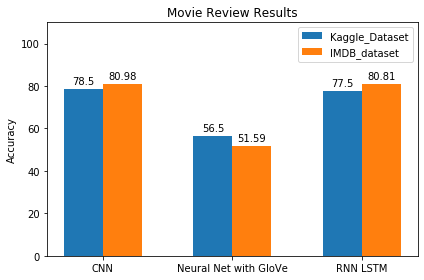

In [0]:
labels = ["CNN", "Neural Net with GloVe", "RNN LSTM"]
kaggle_data = [acc_cnnk, acc_gk, acc_rnnk]
imdb_data = [acc_cnnimdb, acc_gimdb, acc_rnnimdb]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
ax.set_ylim(0,110)
#fig.set_figheight(7)
#fig.set_figwidth(7)
rects1 = ax.bar(x - width/2, kaggle_data, width, label='Kaggle_Dataset')
rects2 = ax.bar(x + width/2, imdb_data, width, label='IMDB_dataset')

ax.set_ylabel('Accuracy')
ax.set_title('Movie Review Results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

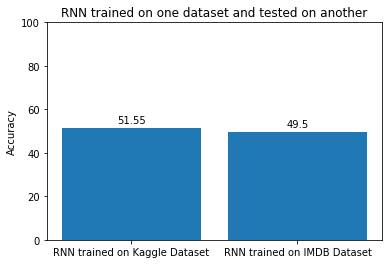

In [0]:
x = [0,.6]
y = [kag_test_acc, imdb_test_acc]
labels = ['RNN trained on Kaggle Dataset', 'RNN trained on IMDB Dataset']

fig, ax = plt.subplots()

ax.set_ylim(0,100)
ax.set_ylabel('Accuracy')
ax.set_title('RNN trained on one dataset and tested on another')
ax.set_xticks(x)
ax.set_xticklabels(labels)

rects = ax.bar(x, y, .5)

autolabel(rects)
plt.show()